# **266 Final Project Fine-Tuning Notebook: LLama 3 8B Text-to-SQL Training**


I will be using the recently released Llama 3.1 8bn parameter model for training a text-to-sql dataset. I will also be using the open-source version of Unsloth instead of Hugging Face to speed up training and reduce memory usage.

In [ ]:
%%capture
# using unsloth, which is faster and less memory than hugging face
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes
!pip install evaluate
!pip install
!pip install tbparse

In [ ]:
from datasets import load_dataset, Dataset, concatenate_datasets, list_metrics,load_metric
import pandas as pd
from unsloth import FastLanguageModel,is_bfloat16_supported
import torch
import tensorboard as tb
from tbparse import SummaryReader
import tbparse
import re
from transformers import AutoTokenizer, TrainingArguments, pipeline, TrainerCallback
from random import randint
import numpy as np
import evaluate
from trl import SFTTrainer
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import os

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [ ]:
# connect to gdrive to save and retrieve trained models locally
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # 4-bit quantization

model_dir="/content/gdrive/MyDrive/models"
checkpoint_dir="/content/gdrive/MyDrive/checkpoints"


Load Llama 3.1 8B Instruct model. Configure Unsloth's Fast Language Model and 4-bit quantization.

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
    # local_files_only=True
)

==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.43.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

Configure LORA adapter for faster training:

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # higher number prevents overfitting but may slow training
    bias = "none",
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 222,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# **Load Text-to-SQL Dataset**

First, configure the prompt formats:

In [ ]:
system_message = """You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA only.
SCHEMA:
{schema}"""

In [ ]:
def create_conversation(examples):
  return {
    "messages": [
      {"role": "system", "content": system_message.format(schema=examples["sql_context"])},
      {"role": "user", "content": examples["sql_prompt"]},
      {"role": "assistant", "content": examples["sql"]}
    ]
  }

Load dataset. I use the synthetic text to sql dataset from gretalai on HuggingFace as our dataset. We will use 5k records from this dataset.

In [ ]:

dataset = load_dataset("gretelai/synthetic_text_to_sql",split='train')


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5851 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)["test"]

NameError: name 'dataset' is not defined

Categorize the SQL into Easy, Medium, Hard categories based on the types of SQL queries

In [ ]:
def update_complexity_column(ds):
    # Modify example based on your criteria
    if ds["sql_complexity"] == 'basic SQL':
        ds["complexity_category"] = "easy"
    elif ds['sql_complexity'] in ['aggregation','single join']:
        ds["complexity_category"] = "medium"
    elif ds['sql_complexity'] in ['multiple_joins','window functions','set operations','subqueries','CTEs']:
        ds["complexity_category"] = "hard"
    return ds

In [ ]:
dataset = dataset.add_column("complexity_category",[""]*len(dataset))
updated_dataset = dataset.map(update_complexity_column)

Flattening the indices:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
updated_dataset_df=updated_dataset.to_pandas()

In [ ]:
updated_dataset_df.loc[:,['sql_complexity','complexity_category']].groupby(['sql_complexity','complexity_category']).size()

,,0
sql_complexity,complexity_category,
CTEs,hard,53
aggregation,medium,4463
basic SQL,easy,9657
multiple_joins,hard,570
set operations,hard,214
single join,medium,2972
subqueries,hard,1351
window functions,hard,720


In [ ]:
updated_dataset_df.head(5)

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation,complexity_category
0,16743,cannabis industry,"Cannabis production data, dispensary sales sta...",basic SQL,basic SQL with a simple select statement,data manipulation,"inserting, updating, or deleting records",How many cannabis strains were deleted from th...,"CREATE TABLE inventory (inventory_id INT, stra...",SELECT COUNT(*) FROM inventory WHERE state = '...,This query counts the number of records in the...,easy
1,19734,marine biology,"Comprehensive data on marine species, oceanogr...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",How many marine mammals are there in each region?,"CREATE TABLE marine_mammals (id INTEGER, name ...","SELECT region, COUNT(*) FROM marine_mammals GR...",The SQL query groups the 'marine_mammals' tabl...,medium
2,62701,climate change,"Climate change data on climate mitigation, cli...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",What is the total CO2 emissions reduction from...,CREATE TABLE adaptation_projects (country VARC...,SELECT SUM(co2_reduction) FROM adaptation_proj...,This query calculates the sum of the 'co2_redu...,easy
3,53201,venture capital,"Company founding data, investment rounds, exit...",multiple_joins,"two or more joins (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the average investment amount for comp...,"CREATE TABLE company (id INT PRIMARY KEY, name...",SELECT AVG(investment.invested_amount) FROM co...,"This query joins the company, investment, and ...",hard
4,7769,venture capital,"Company founding data, investment rounds, exit...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the minimum amount of funding for seri...,"CREATE TABLE funding (company_id INT, round TE...",SELECT MIN(amount) FROM funding JOIN company O...,"The SQL query joins the ""funding"" and ""company...",medium


In [ ]:
updated_dataset_df.loc[:,['complexity_category']].groupby(['complexity_category']).size()

,0
complexity_category,
easy,9657
hard,2908
medium,7435


Format the easy, medium, hard datasets for training, then combine them.

In [ ]:
easy_dataset=Dataset.from_pandas(updated_dataset_df[updated_dataset_df['complexity_category']=='easy'])
medium_dataset=Dataset.from_pandas(updated_dataset_df[updated_dataset_df['complexity_category']=='medium'])
hard_dataset=Dataset.from_pandas(updated_dataset_df[updated_dataset_df['complexity_category']=='hard'])

easy_dataset_formatted= easy_dataset.map(create_conversation, remove_columns=dataset.features,batched = False,)
medium_dataset_formatted= medium_dataset.map(create_conversation, remove_columns=dataset.features,batched = False,)
hard_dataset_formatted= hard_dataset.map(create_conversation, remove_columns=dataset.features,batched = False,)

Map:   0%|          | 0/9657 [00:00<?, ? examples/s]

Map:   0%|          | 0/7435 [00:00<?, ? examples/s]

Map:   0%|          | 0/2908 [00:00<?, ? examples/s]

In [ ]:
combined_dataset = concatenate_datasets([easy_dataset_formatted,medium_dataset_formatted,hard_dataset_formatted])

In [ ]:
# Split the dataset into train, validation, and test sets
combined_dataset_splits = combined_dataset.train_test_split(test_size=0.2)
train_dataset = combined_dataset_splits['train']
eval_test_dataset = combined_dataset_splits['test']
eval_test_dataset_splits = eval_test_dataset.train_test_split(test_size=0.5)
eval_dataset = eval_test_dataset_splits['train']
test_dataset = eval_test_dataset_splits['test']


# **Training**

I use Hugging Face's Supervised Fine-Tuning Trainer (SFTTrainer) to perform the fine-tuning.

In [ ]:
num_steps=3000

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset=eval_dataset,
    # dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps=num_steps,
        logging_steps=25,
        logging_dir = checkpoint_dir,
        # num_train_epochs = 2,
        remove_unused_columns = False,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        # seed = 3405,
        output_dir = checkpoint_dir,
        overwrite_output_dir = True,
        eval_strategy = "steps",
        eval_steps = 25,
        save_strategy = "steps",
        save_steps = 500,
        save_total_limit = 2,
    ),
)

Map (num_proc=2):   0%|          | 0/16000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


Check current memory stats

In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
5.984 GB of memory reserved.


Train the model:

In [ ]:
trainer_stats = trainer.train(resume_from_checkpoint = False)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 16,000 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 3,000
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
25,0.989400,0.526616
50,0.494500,0.474872
75,0.478300,0.462690
100,0.473300,0.459860
125,0.450500,0.452686
150,0.453400,0.447627
175,0.448200,0.440768
200,0.439100,0.441091
225,0.443600,0.438905
250,0.439700,0.435658


Get latest log file, to chart metrics:

In [ ]:
list_of_files = glob.glob(f'{checkpoint_dir}/*')
latest_file = max(list_of_files, key=os.path.getctime)

In [ ]:
log_file=latest_file

Get metrics and convert into dataframe for charting:

In [ ]:
reader = SummaryReader(log_file)
df = reader.scalars
df_metrics=df.loc[df['tag'].isin(['eval/loss','train/loss']),['step','tag','value']].pivot(index='step',columns='tag',values='value')
df_metrics.reset_index(inplace=True)
df_metrics.set_index('step',inplace=True)

Plot Training and Validation Loss

In [ ]:
def make_plot(df:pd.DataFrame,title:str,val_1:str,val_2:str):
  fig, ax = plt.subplots()

  # Plot the two columns as curves
  ax.plot(df.index, df[val_1], label=val_1)
  ax.plot(df.index, df[val_2], label=val_2)

  # Add title, labels, and legend
  ax.set_title(title)
  ax.set_xlabel('Steps')
  ax.set_ylabel('Loss')
  ax.legend()

  # Show the plot
  plt.show()

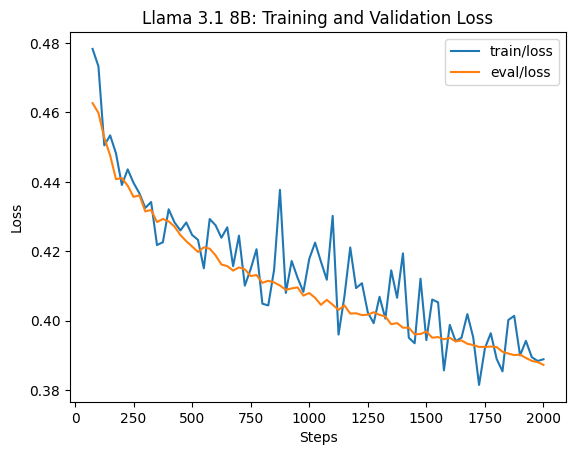

In [ ]:
make_plot(df_metrics[2:80],f'Llama 3.1 8B: Training and Validation Loss','train/loss','eval/loss')

In [ ]:
metrics = trainer_stats.metrics

In [ ]:
trainer_stats

TrainOutput(global_step=3000, training_loss=0.3955473035176595, metrics={'train_runtime': 16369.4334, 'train_samples_per_second': 1.466, 'train_steps_per_second': 0.183, 'total_flos': 2.330467013846139e+17, 'train_loss': 0.3955473035176595, 'epoch': 1.5})

In [ ]:
metrics

{'train_runtime': 16369.4334,
 'train_samples_per_second': 1.466,
 'train_steps_per_second': 0.183,
 'total_flos': 2.330467013846139e+17,
 'train_loss': 0.3955473035176595,
 'epoch': 1.5}

Check final memory and time stats:

In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

16369.4334 seconds used for training.
272.82 minutes used for training.
Peak reserved memory = 11.172 GB.
Peak reserved memory for training = 5.188 GB.
Peak reserved memory % of max memory = 28.238 %.
Peak reserved memory for training % of max memory = 13.113 %.


### Save Model for Inference

In [ ]:
model.save_pretrained(f"{model_dir}/lora_model_big") # Local saving
tokenizer.save_pretrained(f"{model_dir}/lora_model_big")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('/content/gdrive/MyDrive/models/lora_model_big/tokenizer_config.json',
 '/content/gdrive/MyDrive/models/lora_model_big/special_tokens_map.json',
 '/content/gdrive/MyDrive/models/lora_model_big/tokenizer.json')

# **Evaluation**

In [ ]:
# Evaluate the model on the evaluation dataset
eval_results = trainer.evaluate()

# Print the evaluation metrics
print(eval_results)

{'eval_loss': 0.38367462158203125, 'eval_runtime': 145.2747, 'eval_samples_per_second': 13.767, 'eval_steps_per_second': 1.721, 'epoch': 1.5}


Collect stats for Execution Accuracy Metric.
Run the model in a loop and collect stats.

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"{model_dir}/lora_model", # model named saved locally during training
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.43.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
FastLanguageModel.for_inference(model)

In [ ]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM'

Split Test dataset into Easy, Medium, Hard for measuring accuracy in each category separately.

In [ ]:
dataset = load_dataset("gretelai/synthetic_text_to_sql",split='test')

NameError: name 'load_dataset' is not defined

In [ ]:
easy_test_dataset=dataset.filter(lambda example: example['sql_complexity'] in ['basic SQL'])
easy_test_dataset=easy_test_dataset.map(create_conversation, remove_columns=easy_test_dataset.features,batched = False,)
medium_test_dataset=dataset.filter(lambda example: example['sql_complexity'] in ['aggregation','single join'])
medium_test_dataset=medium_test_dataset.map(create_conversation, remove_columns=medium_test_dataset.features,batched = False,)
hard_test_dataset=dataset.filter(lambda example: example['sql_complexity'] in ['multiple_joins','window functions','set operations','subqueries','CTEs'])
hard_test_dataset=hard_test_dataset.map(create_conversation, remove_columns=hard_test_dataset.features,batched = False,)

Filter:   0%|          | 0/5851 [00:00<?, ? examples/s]

Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5851 [00:00<?, ? examples/s]

Map:   0%|          | 0/792 [00:00<?, ? examples/s]

In [ ]:
def evaluate(sample):
    prompt = pipe.tokenizer.apply_chat_template(sample["messages"][:2], tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.01, top_k=50, top_p=0.95, eos_token_id=pipe.tokenizer.eos_token_id, pad_token_id=pipe.tokenizer.pad_token_id)
    predicted_answer = outputs[0]['generated_text'][len(prompt):].strip()
    if predicted_answer == sample["messages"][2]["content"]:
        return 1
    else:
        return 0

success_rate = []
number_of_samples = 300

In [ ]:
# EASY TEST ACCURACY

success_rate = []
for s in tqdm(easy_test_dataset.shuffle().select(range(number_of_samples))):
    success_rate.append(evaluate(s))

# compute accuracy
easy_accuracy = sum(success_rate)/len(success_rate)

print(f"Easy Accuracy: {easy_accuracy*100:.2f}%")

100%|██████████| 300/300 [08:01<00:00,  1.60s/it]

Easy Accuracy: 53.33%


In [ ]:
# MEDIUM TEST ACCURACY

success_rate = []
for s in tqdm(medium_test_dataset.shuffle().select(range(number_of_samples))):
    success_rate.append(evaluate(s))

# compute accuracy
medium_accuracy = sum(success_rate)/len(success_rate)

print(f"Medium Accuracy: {medium_accuracy*100:.2f}%")

100%|██████████| 300/300 [11:56<00:00,  2.39s/it]

Medium Accuracy: 12.33%


In [ ]:
# HARD TEST ACCURACY

success_rate = []
for s in tqdm(hard_test_dataset.shuffle().select(range(number_of_samples))):
    success_rate.append(evaluate(s))

# compute accuracy
hard_accuracy = sum(success_rate)/len(success_rate)

print(f"Hard Accuracy: {hard_accuracy*100:.2f}%")

100%|██████████| 300/300 [14:50<00:00,  2.97s/it]

Hard Accuracy: 3.67%


Plot the Easy, Medium, Hard Categories Accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

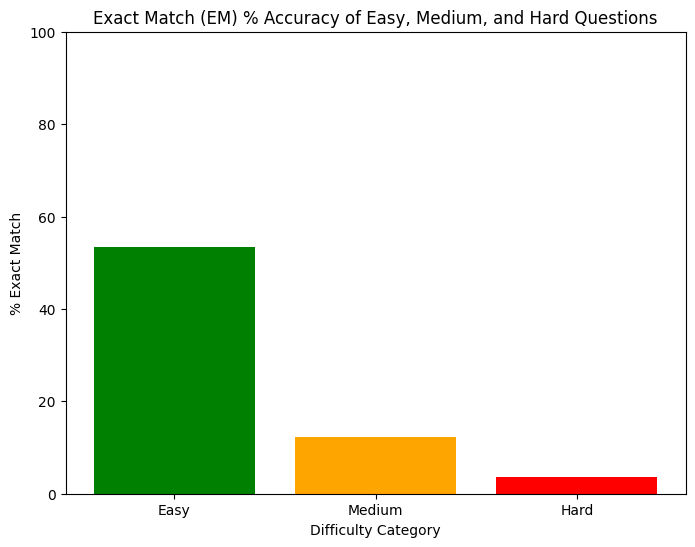

In [ ]:
plt.figure(figsize=(8, 6))  # Set the size of the figure
plt.bar(['Easy','Medium','Hard'], [easy_accuracy*100,medium_accuracy*100,hard_accuracy*100], color=['green', 'orange', 'red'])  # Create bars with different colors

# Add titles and labels
plt.title('Exact Match (EM) % Accuracy of Easy, Medium, and Hard Questions')
plt.xlabel('Difficulty Category')
plt.ylabel('% Exact Match')
plt.ylim(0, 100)

plt.show

# **Exception/Error Analysis**

We will examine some errors in the easy questions category first to understand why the model cannot fully match the expected SQL:

In [ ]:
rand_idx = randint(0, len(easy_test_dataset))

# Test on sample
prompt = pipe.tokenizer.apply_chat_template(easy_test_dataset[rand_idx]["messages"][:2], tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=False, temperature=0.0, top_k=50, top_p=0.1, eos_token_id=pipe.tokenizer.eos_token_id, pad_token_id=pipe.tokenizer.pad_token_id)

print(f"Query:\n{easy_test_dataset[rand_idx]['messages'][1]['content']}")
print(f"Context:\n{easy_test_dataset[rand_idx]['messages'][0]['content']}")
print(f"Original Answer:\n{easy_test_dataset[rand_idx]['messages'][2]['content']}")
print(f"Generated Answer:\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Query:
What is the maximum loan amount for socially responsible loans in the Asia-Pacific region?
Context:
You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA only.
SCHEMA:
CREATE TABLE socially_responsible_loans (loan_id INT, region VARCHAR(20), loan_amount DECIMAL(10,2)); INSERT INTO socially_responsible_loans (loan_id, region, loan_amount) VALUES (101, 'Asia-Pacific', 50000), (102, 'Europe', 30000), (103, 'Asia-Pacific', 70000);
Original Answer:
SELECT MAX(srl.loan_amount) FROM socially_responsible_loans srl WHERE srl.region = 'Asia-Pacific';
Generated Answer:
SELECT MAX(loan_amount) FROM socially_responsible_loans WHERE region = 'Asia-Pacific';
